### Sparse Linear Operator
This is an example of how to create and tune a sparse linear operator.

In [1]:
import torch
import sparta
import matplotlib.pyplot as plt

device = 'cuda:0'

First, we need to create a PyTorch dense linear operator with `in_features` and `out_features` parameters.

Note that the optimal implementation and configuration are different for different batch sizes, so we need to determine the `batch_size` at the very early stage.

In [2]:
batch_size, in_features, out_features = 4096, 3072, 768
dense_linear = torch.nn.Linear(in_features, out_features, device=device)

To build a linear operator with sparse weights, a weight mask tensor is required.

Let's generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

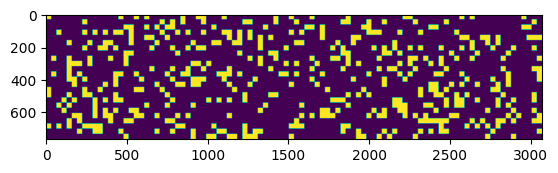

In [3]:
weight_mask = sparta.testing.block_mask((out_features, in_features), block=(32, 32), sparsity=0.8, device=device)
plt.imshow(weight_mask.cpu().numpy())

Create a ```sparta.nn.SparseLinear``` operator using the dense operator and the weight mask.

Next, tune the sparse operator using a sample input. To save time, we will choose random search and take 30 trials here. This step may take a minute.

In [4]:
x = torch.rand((batch_size, in_features), device=device)
sparse_linear = sparta.nn.SparseLinear(dense_linear, weight_mask=weight_mask)

# The tune() function will find the best config,
# build the sparse operator and return the best config.
best_config = sparta.nn.tune(
    sparse_linear,
    sample_inputs=[x],
    algo='rand',
    max_trials=30,
)


print("before serialization", best_config)
import jsonpickle

with open("sparse_linear_best_config.json", "w") as f:
    f.write(jsonpickle.dumps(best_config))
best_config = jsonpickle.loads(
    open("sparse_linear_best_config.json", "r").read()
)
print("after serialization", best_config)

# If you have already tuned once and saved the best config,
# you can skip the tune() step and build the operator directly.
sparse_linear.build(best_config['root'], sample_inputs=[x])

STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:18 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:18 1613216:161321

before serialization {'root': {'forward:C': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 64, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 32}}}
after serialization {'root': {'forward:C': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 64, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 32}}}


STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:21 1613216:1613216 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:21 1613216:161321

Let's check whether the sparse operator works correctly.

In [5]:
sparse_weight = dense_linear.weight * weight_mask
dense_linear.load_state_dict(dict(weight=sparse_weight, bias=dense_linear.bias))
torch.testing.assert_close(sparse_linear(x), dense_linear(x))

Finally, take a look at how much time can be saved by using the sparse linear operator!

In [6]:
dense_latency = sparta.testing.profile(dense_linear, inputs=[x], num_warmups=100, num_iters=100)
print(f'Dense linear forward latency: {dense_latency} ms')
sparse_latency = sparta.testing.profile(sparse_linear, inputs=[x], num_warmups=100, num_iters=100)
print(f'Sparse linear forward latency: {sparse_latency} ms')

Dense linear forward latency: 1.0272425842285156 ms
Sparse linear forward latency: 0.4643577575683594 ms
